## Model with Gaussian separable feature map without mean

### Imports


In [1]:
#!/usr/bin/env python3

from functools import wraps
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn, rand
import numdifftools as nd
import picos as pc
from scipy.integrate import solve_ivp
from scipy.io import loadmat
import time
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

plt.style.use("default")

### Computation time


In [2]:
def runtime(func):
    @wraps(func)
    def runtime_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print("\n", f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return runtime_wrapper

### Read data

In [3]:
name_of_dataset = 'Angle'
#name_of_dataset = 'Sshape'

dataset = loadmat("Dataset/" + name_of_dataset + '.mat')
# Unpack the trajectories and place into x and y used in learning step
num_of_demos = dataset['demos'].shape[1]
size_of_state = dataset['demos'][0, 0][0, 0][0].shape[0]
dim_of_function = size_of_state

#### Training demonstrations

In [4]:
num_of_train_datasets = 4
x_cell = None 
y_cell = None
init_position_of_demos = np.zeros((size_of_state, num_of_train_datasets))
# Concatenating the dataseries of position and velocities
for i in range(0, num_of_train_datasets):
    demo_struct = dataset['demos'][0,i][0,0]
    position_dataseries = dataset['demos'][0,i][0,0][0]
    velocity_dataseries = dataset['demos'][0,i][0,0][2]
    init_position_of_demos[:,i] = position_dataseries[:,0]
    # create x_cell if not existing
    if x_cell is None : 
        x_cell = position_dataseries
    else : 
        x_cell = np.concatenate((x_cell, position_dataseries), axis = 1)
    if y_cell is None : 
        y_cell = velocity_dataseries
    else : 
        y_cell = np.concatenate((y_cell, velocity_dataseries), axis = 1)

x_train = x_cell
y_train = y_cell

num_of_points = x_train.shape[1]

# Get time info for simulating the learnt system later
time_step = dataset['dt'][0,0]

len_of_dataseries = dataset['demos'][0, 0][0,0][0].shape[1]

concatenate = np.concatenate((np.array([[0]]), time_step * np.ones((1, len_of_dataseries - 1))),axis=1)
time_series = np.cumsum(concatenate)
num_of_timesteps = len_of_dataseries

# Intial starting point for the simulated trajectory using learnt model
init_condition = init_position_of_demos.mean(axis = 1) # computes the mean across each columns

timespan = np.array([time_series[0],time_series[-1]])
t_series = np.linspace(time_series[0],time_series[-1], 1000)

#### Plot training trajectories

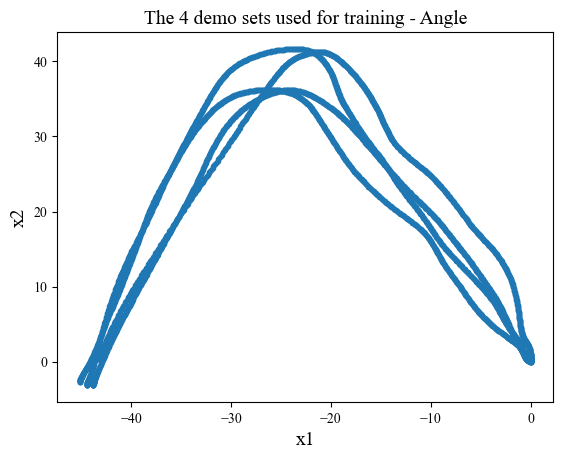

In [5]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "Times New Roman",
})

fig_dataset = plt.figure(1)
plt.title('The 4 demo sets used for training - ' + name_of_dataset, fontsize=14)
plt.plot(x_train[0, :], x_train[1, :], '.')
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
fig_dataset.show()
axes = plt.gca()

#### Define vector-field and axis


In [6]:
# Get lower and upper bound for plotting from dataset figure
lower_bound_x1 = axes.get_xlim()[0]
upper_bound_x1 = axes.get_xlim()[1]
lower_bound_x2 = axes.get_ylim()[0]
upper_bound_x2 = axes.get_ylim()[1]

num_of_points_for_plot = 25

x1 = np.linspace(lower_bound_x1, upper_bound_x1, num_of_points_for_plot)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points_for_plot)

# Base point or starting point for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

# Calculate df/dt for each point
t = 0

### Model without mean

#### Functions

In [7]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)

def psi_vector(x, w, b, d):
    psi_vector = np.zeros(d)
    for i in range(d):
        x = x.reshape((-1,))
        psi_vector[i] = psi(x, w[:, i], b[:, i])
    return np.array(psi_vector)

def capital_psi(x, w, b, d, dim):
    psi = psi_vector(x, w, b, d)
    return np.kron(psi, np.eye(dim))

def phi(x, w, b, N, d, dim):
    phi = np.zeros((dim*N, dim*d))
    for i in range(0, N):
        psi = capital_psi(x[:, i], w, b, d, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

#### Variables

In [8]:
sigma = 10
lambda_ = 0.1
num_of_constraint_points = 250
num_of_samples = 100
mu = 0.0

if name_of_dataset == 'Sshape':
    num_of_samples = 200

# Generate parameters for feature map
#w = randn(size_of_state, num_of_samples)/sigma
#b = rand(1, num_of_samples)*2*np.pi

# Load saved paratmeters
w = np.load('RFF_parameters/w_'+name_of_dataset+'_no_mean.npy') 
b = np.load('RFF_parameters/b_'+name_of_dataset+'_no_mean.npy')

#### Alpha


In [9]:
@runtime
def alpha_approx(x, y, w, b, dim, d, lam, N):
    phi_ = phi(x, w, b, N, d, dim)
    alpha_inv_part = np.linalg.inv(phi_.T @ phi_ + lam*np.eye(dim*d))
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    alpha = alpha_inv_part @ (phi_.T @ y_reshaped)
    return alpha

#### Solve regression problem without contraction


In [10]:
alpha_rff = alpha_approx(x_train, y_train, w, b, dim_of_function, num_of_samples, lambda_, num_of_points)


 Function alpha_approx took 8.0618 seconds


##### Function to learn model

In [11]:
def learnt_model(t, x):
    func = capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_rff
    return func

#### Simulate vector field


In [12]:
data_series = solve_ivp(learnt_model, timespan, init_condition, t_eval = t_series).y

#### Plot vector field for learnt model

In [13]:
u_learnt = np.zeros(X1.shape)
v_learnt = np.zeros(X1.shape)

# for loop to get the velocity at each point with the learnt model
for (i, j), value in np.ndenumerate(X1):
    Y_prime = learnt_model(t, np.array([value, X2[i, j]]))
    u_learnt[i, j] = Y_prime[0]
    v_learnt[i, j] = Y_prime[1]

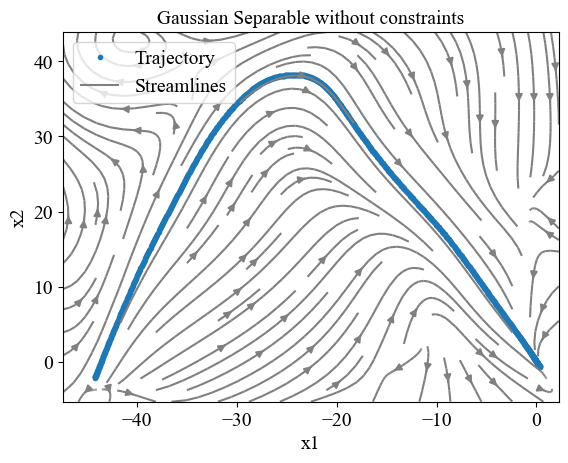

In [14]:
fig_learntmodel = plt.figure(1)
plt.title('Gaussian Separable without constraints', fontsize=14)
plt.plot(data_series[0, :], data_series[1, :], '.', linewidth=0.1)
plt.streamplot(X1, X2, u_learnt, v_learnt, density=1.1, color='gray')
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.legend(['Trajectory', 'Streamlines'], loc="upper left", frameon=True, prop={'size': 14})
fig_learntmodel.show()

#### Reproducing accuracy


The trajectory error:  [2.96429667 2.72439819 3.62061398]
The mean trajectory error (MTE):  3.103102946326634


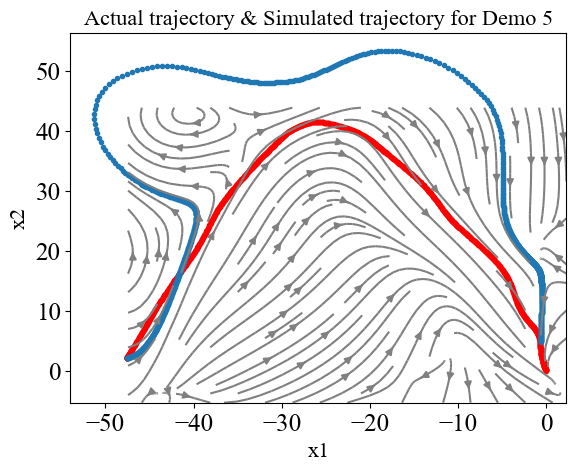

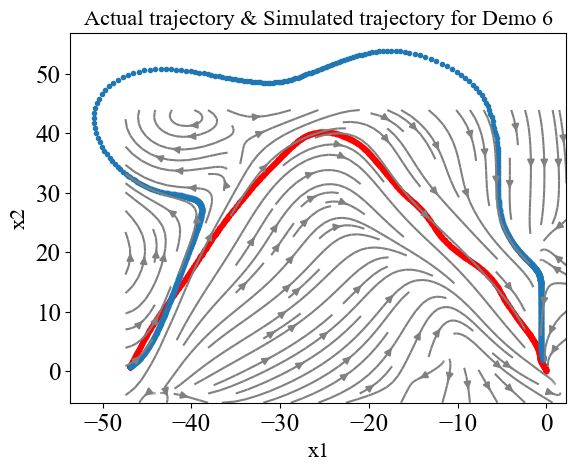

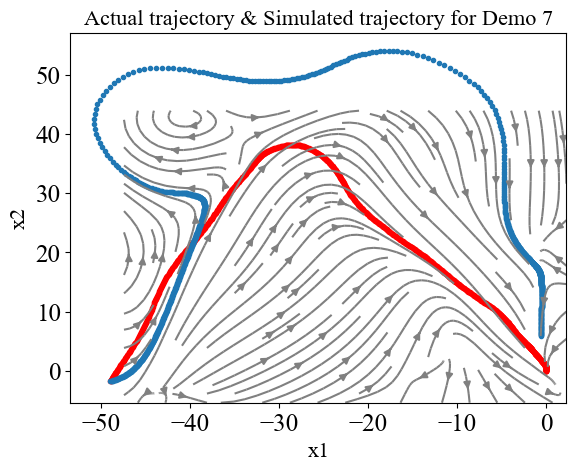

In [15]:
num_of_test_datasets = num_of_demos - num_of_train_datasets
trajectory_error = np.zeros(num_of_test_datasets)

for i in range(num_of_test_datasets):
    demo_pos = num_of_train_datasets + i
    actual_trajectory = dataset['demos'][0, demo_pos][0, 0][0]
    actual_time = dataset['demos'][0, demo_pos][0, 0][1]
    timespan = np.array([actual_time[:, 0], actual_time[:, -1]])
    initial_condition = actual_trajectory[:, 0]
    simulated_trajectory = solve_ivp(learnt_model, timespan, initial_condition, t_eval=actual_time[0]).y
    error = np.mean(np.linalg.norm(actual_trajectory - simulated_trajectory, ord=2, axis=0) / actual_time[:, -1])
    trajectory_error[i] = error
    demo_number = demo_pos+1
    fig_learntmodel = plt.figure(i+num_of_train_datasets)
    plt.title('Actual trajectory & Simulated trajectory for Demo ' + str(demo_number), fontsize=16)
    plt.plot(actual_trajectory[0, :], actual_trajectory[1, :], '.', linewidth=0.1, color='r')
    plt.plot(simulated_trajectory[0, :], simulated_trajectory[1, :], '.', linewidth=0.1)
    plt.streamplot(X1, X2, u_learnt, v_learnt, density=1.1, color='gray')
    plt.xlabel('x1', fontsize=16)
    plt.ylabel('x2', fontsize=16)
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    fig_learntmodel.show()

print('The trajectory error: ', trajectory_error)

trajectory_mean_error = np.mean(trajectory_error)
print('The mean trajectory error (MTE): ', np.mean(trajectory_error))

#### Save satisfactory feature map parameters

In [16]:
#np.save('RFF_parameters/w_'+name_of_dataset+'_no_mean', w)
#np.save('RFF_parameters/b_'+name_of_dataset+'_no_mean', b)